# Carregando DFS

In [1]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from functools import reduce
from statistics import multimode
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set()
#pd.set_option('float_format', '{:.3f}'.format)

In [2]:
nam = pd.read_csv('IMDb_names.csv')

In [3]:
mov = pd.read_csv('IMDb_movies.csv')

In [4]:
rat = pd.read_csv('IMDb_ratings.csv')

In [5]:
url = 'https://www.macrotrends.net/countries/USA/united-states/inflation-rate-cpi'
tables=pd.read_html(url,match='Historical Data')
inflacao = tables[0]
inflacao.columns = inflacao.columns.droplevel()
inflacao['Inflation Rate (%)']=inflacao['Inflation Rate (%)'].str.replace('%','').astype('float32')
inflacao.drop(columns='Annual Change',inplace=True)
inflacao['inflacao'] = 1+inflacao['Inflation Rate (%)']/100
inflacao.sort_values('Year',inplace=True)
inflacao.set_index('Year',inplace=True)
def inflacao_acc_gen(df,ano1,ano_base):
    acumulada = df.loc[ano1+1:ano_base]['inflacao'].product()
    return acumulada
ano_base=2020
inflacao['acc_inflacao']=inflacao.index.map(lambda x: inflacao_acc_gen(inflacao, x,ano_base=ano_base))

In [6]:
inflacao.head()

,Inflation Rate (%),inflacao,acc_inflacao
Year,,,
1960,1.460,1.015,8.751
1961,1.070,1.011,8.658
1962,1.200,1.012,8.555
1963,1.240,1.012,8.450
1964,1.280,1.013,8.344


# Criando funcoes

In [7]:
infla = 'Inflation Rate (%)'
def variacao_infla(ano1, ano2):
    interval = len(inflacao.loc[ano1:ano2])-1
    anual = inflacao.loc[ano1+1:ano2][infla].mean()
    return (anual,interval)

In [8]:
def valor_real(variacao_anual,intervalo, valor):
    adicionar = variacao_anual*intervalo*valor/100
    corrigido = valor+adicionar
    return corrigido

# Manipulando df

In [9]:
nam['known_for_titles']=nam['known_for_titles'].str.split(',')

In [10]:
mov['actors']=mov['actors'].str.split(', ')

In [11]:
mov['genre']=mov['genre'].str.split(', ')

# Criando df`s

In [103]:
filmes_dollar = mov[['title','actors','director','year','avg_vote','budget']]
mask = filmes_dollar['budget'].apply(lambda x: True if '$' in str(x) else False).fillna(False)
filmes_dollar=filmes_dollar[mask]
filmes_dollar['budget']=filmes_dollar['budget'].str.replace('$','').astype('int64')

<ipython-input-103-4406f26a02ec>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  filmes_dollar['budget']=filmes_dollar['budget'].str.replace('$','').astype('int64')


In [104]:
filmes_2010 = mov[['imdb_title_id','title','year','director','actors','avg_vote','votes']]
mask = filmes_2010['year']==2010
filmes_2010=filmes_2010[mask]

In [105]:
generos = mov[['genre','year']]

# Análises

## 10 Filmes mais caros de todos os tempos(em dollar)

In [106]:
filmes_dollar = filmes_dollar[filmes_dollar['year']>1960]
mask = lambda df: df['budget']*inflacao.loc[df['year']]['acc_inflacao']
filmes_dollar['budget_ajustado']=filmes_dollar.apply(mask, axis=1).astype('int64')
caros = filmes_dollar.sort_values('budget_ajustado',ascending=False).head(10)
caros

,title,actors,director,year,avg_vote,budget,budget_ajustado
14322,Dauriya,"[Vitali Solomin, Petr Shelokhonov, Yefim Kopel...",Viktor Tregubovich,1972,6.500,70000000,433214454
45864,Pirates of the Caribbean: At World's End,"[Johnny Depp, Geoffrey Rush, Orlando Bloom, Ke...",Gore Verbinski,2007,7.100,300000000,374411416
10915,Cleopatra,"[Elizabeth Taylor, Richard Burton, Rex Harriso...",Joseph L. Mankiewicz,1963,7.000,44000000,371820846
71243,Avengers: Endgame,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...","Anthony Russo, Joe Russo",2019,8.500,356000000,360378805
41702,Superman Returns,"[Brandon Routh, Kate Bosworth, Kevin Spacey, J...",Bryan Singer,2006,6.000,270000000,346573923
65276,Star Wars: Episode VIII - The Last Jedi,"[Mark Hamill, Carrie Fisher, Adam Driver, Dais...",Rian Johnson,2017,7.100,317000000,334679064
71242,Avengers: Infinity War,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...","Anthony Russo, Joe Russo",2018,8.500,321000000,330829893
30262,Titanic,"[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",James Cameron,1997,7.800,200000000,322460341
44344,Spider-Man 3,"[Tobey Maguire, Kirsten Dunst, James Franco, T...",Sam Raimi,2007,6.200,258000000,321993817
50575,Justice League,"[Ben Affleck, Henry Cavill, Amy Adams, Gal Gad...",Zack Snyder,2017,6.400,300000000,316730976


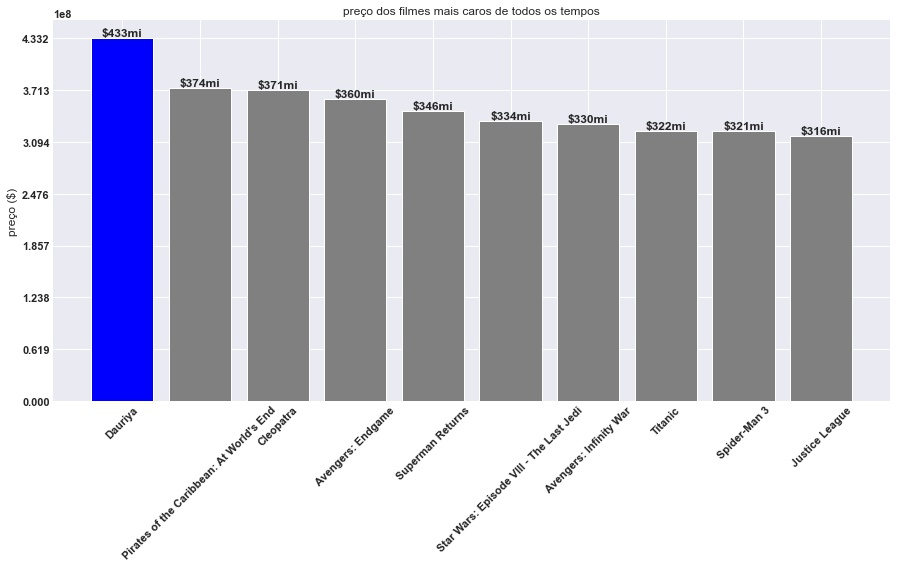

In [87]:
plt.figure(figsize = (15,7))
plt.xticks(rotation=45)
cores = []
gra = plt.bar(caros['title'], caros['budget_ajustado'], color = [
    'blue',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5'],
    edgecolor = 'white')
for rect in gra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height,'$'+str(height)[0:'{0:,}'.format(height).index(',')]+'mi', ha='center', va='bottom')
plt.yticks(np.linspace(0,433214454,8))
plt.title('preço dos filmes mais caros de todos os tempos')
plt.ylabel('preço ($)')
plt.show()

## 10 filmes com maior lucro absoluto de todos os tempos

In [133]:
rentaveis = filmes_dollar
rentaveis['worlwide_gross_income'] = mov['worlwide_gross_income']
rentaveis = rentaveis.dropna()
rentaveis['worlwide_gross_income']=rentaveis['worlwide_gross_income'].str.replace('$','').astype('int64')
mask = lambda df: df['worlwide_gross_income']*inflacao.loc[df['year']]['acc_inflacao']
rentaveis['WGI_ajustado']=rentaveis.apply(mask, axis=1).astype('int64')
rentaveis['lucro'] = rentaveis['WGI_ajustado']-rentaveis['budget_ajustado']

<ipython-input-133-5a322c73605d>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  rentaveis['worlwide_gross_income']=rentaveis['worlwide_gross_income'].str.replace('$','').astype('int64')
<ipython-input-133-5a322c73605d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentaveis['worlwide_gross_income']=rentaveis['worlwide_gross_income'].str.replace('$','').astype('int64')
<ipython-input-133-5a322c73605d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [18]:
maior_lucro = rentaveis.sort_values('lucro',ascending=False).head(10).reset_index(drop=True)
maior_lucro

,title,actors,director,year,avg_vote,budget,budget_ajustado,worlwide_gross_income,WGI_ajustado,lucro
0,Star Wars,"[Mark Hamill, Harrison Ford, Carrie Fisher, Pe...",George Lucas,1977,8.600,11000000,46974610,775512064,3311761546,3264786936
1,Titanic,"[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",James Cameron,1997,7.800,200000000,322460341,2187463944,3526851851,3204391510
2,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,2009,7.800,237000000,285876011,2789968301,3365337600,3079461589
3,The Exorcist,"[Ellen Burstyn, Max von Sydow, Lee J. Cobb, Ki...",William Friedkin,1973,8.000,11000000,64114274,441306145,2572183919,2508069645
4,Avengers: Endgame,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...","Anthony Russo, Joe Russo",2019,8.500,356000000,360378805,2797800564,2832213551,2471834746
5,Jaws,"[Roy Scheider, Robert Shaw, Richard Dreyfuss, ...",Steven Spielberg,1975,8.000,7000000,33663373,471203004,2266040418,2232377045
6,E.T. the Extra-Terrestrial,"[Dee Wallace, Henry Thomas, Peter Coyote, Robe...",Steven Spielberg,1982,7.800,10500000,28164866,792910554,2126878117,2098713251
7,Star Wars: Episode VII - The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",J.J. Abrams,2015,7.900,245000000,267501712,2068223624,2258176984,1990675272
8,One Hundred and One Dalmatians,"[Rod Taylor, J. Pat O'Malley, Betty Lou Gerson...","Clyde Geronimi, Hamilton Luske",1961,7.200,4000000,34631694,216026182,1870338200,1835706506
9,Avengers: Infinity War,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...","Anthony Russo, Joe Russo",2018,8.500,321000000,330829893,2048359754,2111086102,1780256209


In [20]:
transpose = maior_lucro[['title','budget_ajustado','lucro']].T
transpose.columns = transpose.loc['title']
transpose.reset_index(inplace=True)
transpose.drop(index=0, inplace=True)
transpose.reset_index(drop=True,inplace=True)

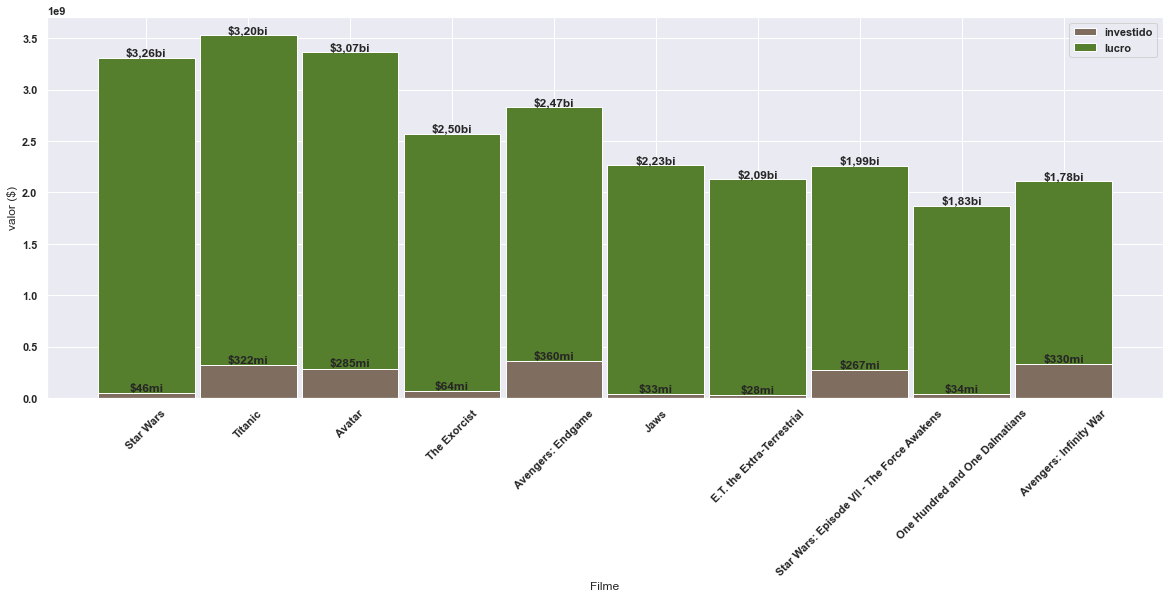

In [22]:
rc('font', weight='bold')
r = [0,1,2,3,4,5,6,7,8,9]
names = maior_lucro['title']
barWidth = .95

plt.figure(figsize = (20,7))

gra1 = plt.bar(r, maior_lucro['budget_ajustado'], color='#7f6d5f', edgecolor='white', width=barWidth)
gra2 = plt.bar(r, maior_lucro['lucro'], bottom=maior_lucro['budget_ajustado'], color='#557f2d', edgecolor='white', width=barWidth)


rects_gra1 = []
for rect in gra1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '$'+str(height)[0:'{0:,}'.format(height).index(',')]+'mi', ha='center', va='bottom')
    rects_gra1.append(rect)

for rect in gra2:
    for rect1 in rects_gra1:
        height = rect.get_height() + rect1.get_height()
        height2 = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '$'+'{0:,}'.format(height2)[0:4]+'bi'.replace(',','.'), ha='center', va='bottom')
        rects_gra1.remove(rect1)
        break

plt.xticks(rotation=45)
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")
plt.ylabel('valor ($)')
plt.xlabel('Filme')
plt.legend(['investido', 'lucro'], loc=1)
plt.show()

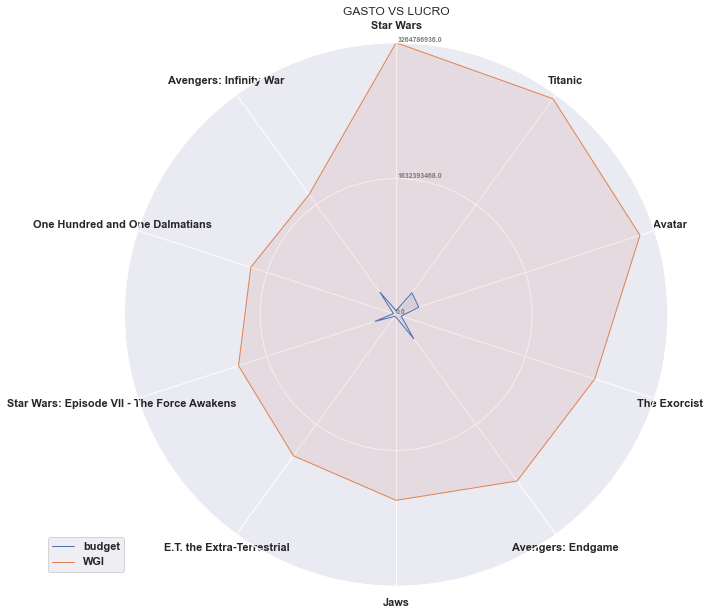

In [23]:
plt.figure(figsize = (20,10))
categories=list(transpose)[1:]
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
ax.set_rlabel_position(0.4)
plt.yticks(np.linspace(0,3264786936,3), np.linspace(0,3264786936,3), color="grey", size=7)
plt.ylim(0,3264786936)

values=transpose.loc[0].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="budget")
ax.fill(angles, values, 'b', alpha=0.1)

values=transpose.loc[1].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="WGI")
ax.fill(angles, values, 'r', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.01, 0.1))

plt.title('GASTO VS LUCRO')
plt.show()

## 10 filmes mais rentaveis de todos os tempos

In [134]:
rentaveis['rentabilidade (%)'] = (rentaveis['WGI_ajustado']-rentaveis['budget_ajustado'])/rentaveis['budget_ajustado']
rentaveis2 = rentaveis
#rentaveis['rentabilidade (%)'] = rentaveis['rentabilidade (%)'].apply(lambda x: str(round(x,2))+'%')

<ipython-input-134-33b40f7971c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rentaveis['rentabilidade (%)'] = (rentaveis['WGI_ajustado']-rentaveis['budget_ajustado'])/rentaveis['budget_ajustado']


In [135]:
rentaveis = rentaveis.sort_values('rentabilidade (%)',ascending=False).head(10).reset_index(drop=True)
rentaveis

,title,actors,director,year,avg_vote,budget,budget_ajustado,worlwide_gross_income,WGI_ajustado,lucro,rentabilidade (%)
0,Poltergeist,"[Craig T. Nelson, JoBeth Williams, Beatrice St...",Tobe Hooper,1982,7.300,20,53,77142388,206924294,206924241,3904230.962
1,Fetih 1453,"[Devrim Evin, Ibrahim Celikkol, Dilek Serbest,...",Faruk Aksoy,2012,6.700,18,20,34484837,38867222,38867202,1943360.100
2,Türk Isi Dondurma,"[Ali Atay, Erkan Kolçak Köstendil, Sebnem Bozo...",Can Ulkay,2019,6.600,21,21,1289283,1305141,1305120,62148.571
3,Paranormal Activity,"[Katie Featherston, Micah Sloat, Mark Fredrich...",Oren Peli,2007,6.300,15000,18720,193355800,241315396,241296676,12889.780
4,Ri-teon,"[Myung-Min Kim, Joon-Sang Yoo, Tae-woo Kim, Yu...",Kyu-maan Lee,2007,6.400,1000,1248,4569780,5703259,5702011,4568.919
5,The Blair Witch Project,"[Heather Donahue, Joshua Leonard, Michael C. W...","Daniel Myrick, Eduardo Sánchez",1999,6.500,60000,93220,248639099,386302468,386209248,4142.987
6,The Gallows,"[Reese Mishler, Pfeifer Brown, Ryan Shoos, Cas...","Travis Cluff, Chris Lofing",2015,4.200,100000,109184,42964410,46910421,46801237,428.646
7,Rough,"[Masami Nagasawa, Mokomichi Hayami, Tsuyoshi A...",Kentarô Ohtani,2006,5.900,10000,12836,3383339,4342878,4330042,337.336
8,El mariachi,"[Carlos Gallardo, Consuelo Gómez, Jaime de Hoy...",Robert Rodriguez,1992,6.900,7000,12911,2040920,3764533,3751622,290.576
9,Offside,"[Mohammad Asarian, Sima Mobarak-Shahi, Shayest...",Jafar Panahi,2006,7.300,2500,3209,551169,707484,704275,219.469


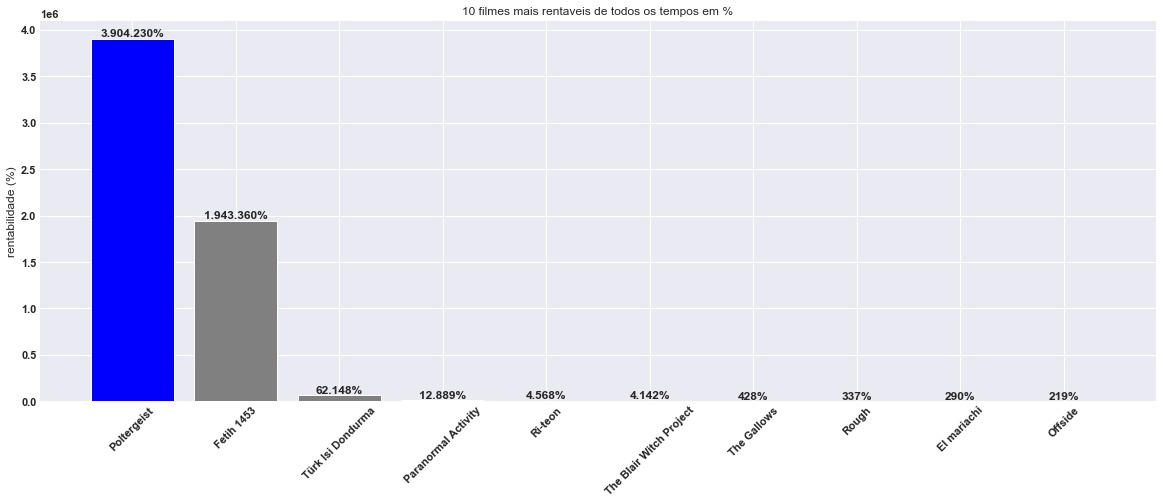

In [86]:
plt.figure(figsize = (20,7))
plt.xticks(rotation=45)
gra = plt.bar(rentaveis['title'], rentaveis['rentabilidade (%)'], color = [
    'blue',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5'],
    edgecolor = 'white')
for rect in gra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{0:,}'.format(int(height)).replace(',','.')+'%', ha='center', va='bottom')
plt.ylabel('rentabilidade (%)')
plt.title('10 filmes mais rentaveis de todos os tempos em %')

plt.show()

## 10 melhores filmes de 2010

### Por quantidade de votos e media de classificacao

In [27]:
mask = filmes_2010['votes'] > filmes_2010['votes'].quantile(0.99)
dados = filmes_2010[mask].sort_values('votes',ascending=False).head(20).sort_values('avg_vote',ascending=False).head(10).reset_index(drop=True)
dados = dados.sort_values('avg_vote',ascending=False)
dados

,imdb_title_id,title,year,director,actors,avg_vote,votes
0,tt1375666,Inception,2010,Christopher Nolan,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",8.800,1892929
1,tt0435761,Toy Story 3,2010,Lee Unkrich,"[Tom Hanks, Tim Allen, Joan Cusack, Ned Beatty...",8.300,707349
2,tt1130884,Shutter Island,2010,Martin Scorsese,"[Leonardo DiCaprio, Mark Ruffalo, Ben Kingsley...",8.100,1036325
3,tt0892769,How to Train Your Dragon,2010,"Dean DeBlois, Chris Sanders","[Jay Baruchel, Gerard Butler, Craig Ferguson, ...",8.100,625491
4,tt0947798,Black Swan,2010,Darren Aronofsky,"[Natalie Portman, Mila Kunis, Vincent Cassel, ...",8.000,661882
5,tt1504320,The King's Speech,2010,Tom Hooper,"[Colin Firth, Helena Bonham Carter, Derek Jaco...",8.000,604763
6,tt0964517,The Fighter,2010,David O. Russell,"[Mark Wahlberg, Christian Bale, Amy Adams, Mel...",7.800,321696
7,tt0398286,Tangled,2010,"Nathan Greno, Byron Howard","[Mandy Moore, Zachary Levi, Donna Murphy, Ron ...",7.700,375980
8,tt0926084,Harry Potter and the Deathly Hallows: Part 1,2010,David Yates,"[Bill Nighy, Emma Watson, Richard Griffiths, H...",7.700,437481
9,tt1285016,The Social Network,2010,David Fincher,"[Jesse Eisenberg, Rooney Mara, Bryan Barter, D...",7.700,579926


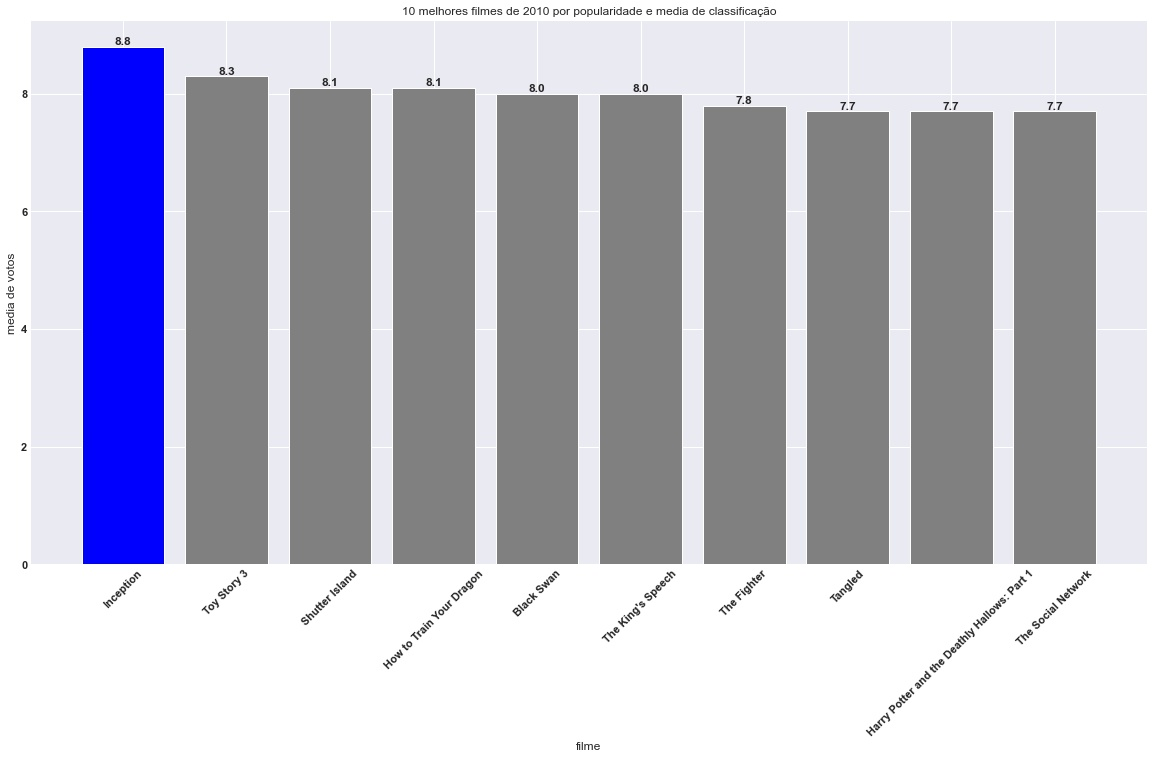

In [85]:
plt.figure(figsize = (20,10))
plt.xticks(rotation=45)
gra = plt.bar(dados['title'], dados['avg_vote'], color = [
    'blue',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5'],
    edgecolor = 'white')
for rect in gra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{0:,}'.format(height).replace(',','.'), ha='center', va='bottom')
plt.ylabel('media de votos')
plt.xlabel('filme')
plt.title('10 melhores filmes de 2010 por popularidade e media de classificação')

plt.show()

### Por score (media*quantidade)

In [29]:
f_2010 = filmes_2010['score'] = filmes_2010['avg_vote']*filmes_2010['votes']
f_2010 = filmes_2010.sort_values('score',ascending=False).head(10)

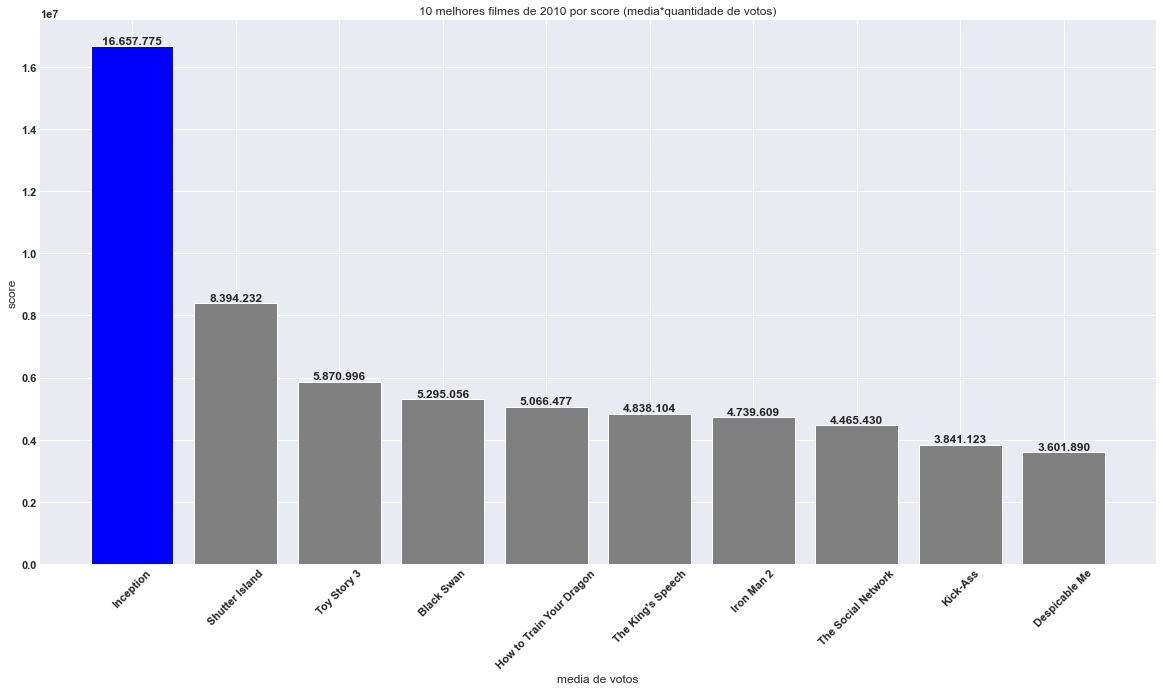

In [84]:
plt.figure(figsize = (20,10))
plt.xticks(rotation=45)
gra = plt.bar(f_2010['title'], f_2010['score'], color = [
    'blue',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5'],
    edgecolor = 'white')
for rect in gra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{0:,}'.format(int(height)).replace(',','.'), ha='center', va='bottom')
plt.ylabel('score')
plt.xlabel('media de votos')
plt.title('10 melhores filmes de 2010 por score (media*quantidade de votos)')

plt.show()

## Genero mais produzido de todos os tempos

In [31]:
gen = pd.DataFrame(generos.explode('genre')['genre'].value_counts()).rename(columns={'genre':'total'}).head(15)
gen2 =  pd.DataFrame(generos.explode('genre')['genre'].value_counts()).rename(columns={'genre':'total'})
gen.head(1)

,total
Drama,44404


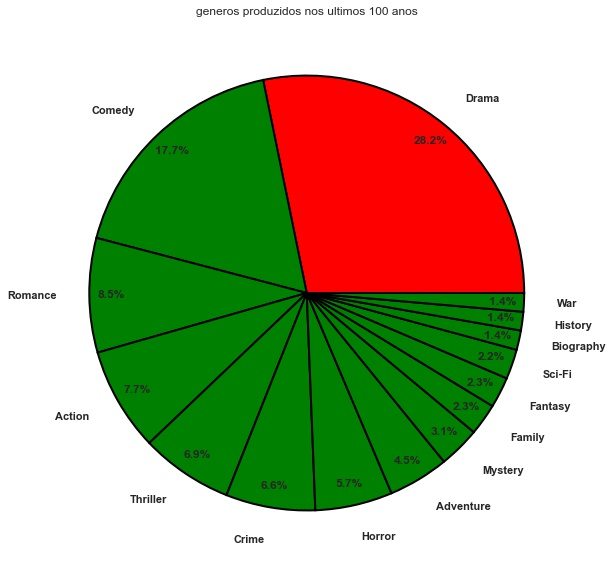

In [32]:
%config InlineBackend.figure_format = 'jpg'
plt.figure(figsize = (20,10))
cores = ['red' if qtd == gen.max()['total'] else 'green' for qtd in gen['total']]
pizza = plt.pie(gen['total'], labels = gen.index, colors = cores, autopct = '%1.1f%%',pctdistance = .9, labeldistance=1.15, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'black' })
plt.title('generos produzidos nos ultimos 100 anos')
plt.show()

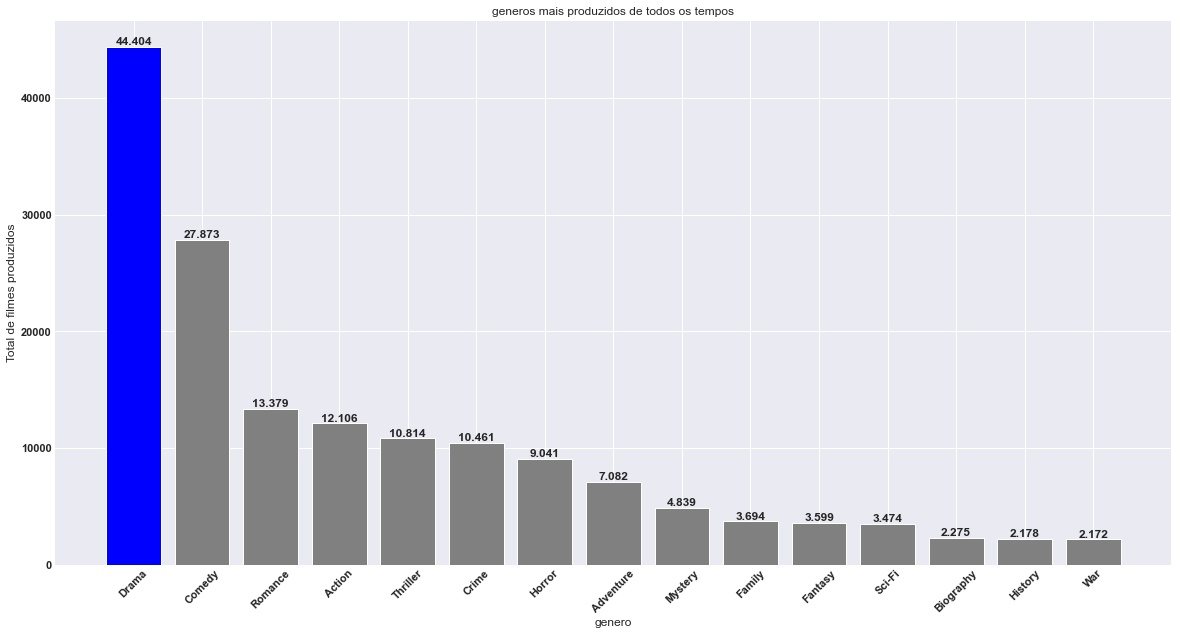

In [82]:
plt.figure(figsize = (20,10))
plt.xticks(rotation=45)
gra = plt.bar(gen.index, gen['total'], color = [
    'blue',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5'],
    edgecolor = 'white')
for rect in gra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{0:,}'.format(height).replace(',','.'), ha='center', va='bottom')
plt.title('generos mais produzidos de todos os tempos')
plt.ylabel('Total de filmes produzidos')
plt.xlabel('genero')
plt.show()

## Genero mais produzido por decada 10s - 2010s

In [34]:
tabela = ['0','10','20','30','40','50','60','70','80','90','2000','2010']
bins2 = [1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]
generos['anos']=pd.cut(generos['year'],bins=bins2,labels=tabela)
genero_dec = generos.explode('genre')
genero_dec.drop(columns='year',inplace=True)
genero_dec = pd.DataFrame(genero_dec.groupby('anos')['genre'].apply(list))
genero_dec['mais feito'] = genero_dec.index.map(lambda x: genero_dec.loc[x].explode('genre').value_counts().head(1).reset_index()['index'][0])
genero_dec['quantidade'] = genero_dec.index.map(lambda x: genero_dec.loc[x].explode('genre').value_counts().max())
genero_dec.drop(columns='genre', index='0',inplace=True)

<ipython-input-34-9c27df333b07>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generos['anos']=pd.cut(generos['year'],bins=bins2,labels=tabela)


In [35]:
genero_dec

,mais feito,quantidade
anos,,
10,Drama,153
20,Drama,524
30,Drama,1490
40,Drama,1571
50,Drama,2150
60,Drama,2508
70,Drama,3141
80,Drama,3484
90,Drama,5704


In [36]:
init = pd.DataFrame(generos.explode('genre').drop(columns='year').groupby('anos')['genre'].apply(list)).explode('genre').reset_index()
all_gen=pd.DataFrame(init.groupby('anos')['genre'].apply(list)).reset_index()
all_gen['qtd'] = all_gen['genre'].map(lambda x: dict(collections.Counter(x)))
all_gen.drop(columns='genre', inplace=True)
final_gen = pd.DataFrame(all_gen['qtd'].to_list()).set_index(all_gen['anos']).fillna(0)
final_gen.reset_index(inplace=True)
#final_gen

In [37]:
final_gen.describe().T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Drama,12.000,3700.333,4141.085,1.000,1247.500,2328.000,4038.000,12846.000
Comedy,12.000,2322.750,2556.509,0.000,778.500,1361.500,2960.000,7891.000
Romance,12.000,1114.917,1118.186,0.000,566.250,729.500,1155.250,3324.000
Action,12.000,1008.833,1197.879,0.000,189.000,441.500,1483.500,3736.000
Thriller,12.000,901.167,1310.926,0.000,73.750,312.500,995.500,4305.000
Crime,12.000,871.750,800.999,1.000,361.250,634.500,1108.750,2402.000
Horror,12.000,753.417,1054.634,0.000,77.000,329.500,859.500,3485.000
Adventure,12.000,590.167,518.095,0.000,256.000,569.500,726.250,1763.000
Mystery,12.000,403.250,462.401,0.000,134.000,281.000,393.750,1546.000
Family,12.000,307.833,362.812,0.000,47.500,190.500,390.750,1130.000


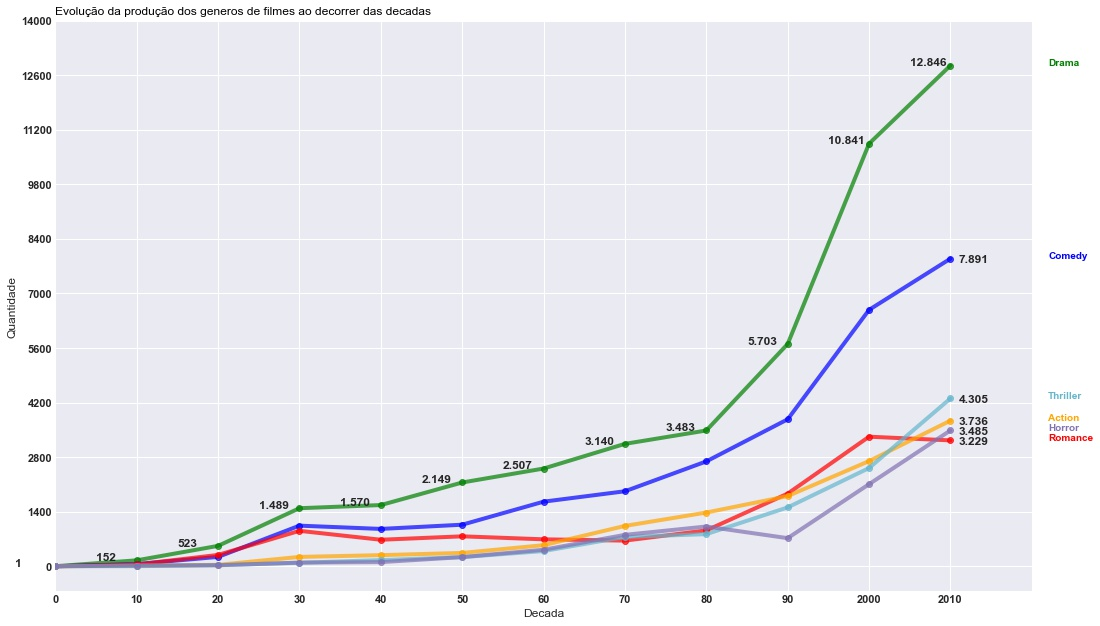

In [38]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots()

fig.set_size_inches(17.5, 10.5)
'''for column in final_gen.drop('anos', axis=1):
    ax.plot(final_gen['anos'], final_gen[column], marker='x', color='grey', linewidth=1, alpha=0.4)'''
ax.plot(final_gen['anos'], final_gen['Drama'], marker='o', color='green', linewidth=4, alpha=0.7)
ax.plot(final_gen['anos'], final_gen['Comedy'], marker='o', color='blue', linewidth=4, alpha=0.7)
ax.plot(final_gen['anos'], final_gen['Romance'], marker='o', color='red', linewidth=4, alpha=0.7)
ax.plot(final_gen['anos'], final_gen['Action'], marker='o', color='orange', linewidth=4, alpha=0.7)
ax.plot(final_gen['anos'], final_gen['Thriller'], marker='o', color='c', linewidth=4, alpha=0.7)
ax.plot(final_gen['anos'], final_gen['Horror'], marker='o', color='m', linewidth=4, alpha=0.7)


ax.set_xlim(0,12)

#num=0
'''for i in final_gen.values[11][1:]:
    num+=1
    name=list(final_gen)[num]
    if name != 'Drama' and name != 'Comedy' and name != 'Romance' and name != 'Action' and name != 'Thriller' and name != 'Horror':
        ax.text(12.2, i, name, horizontalalignment='left', size='small', color='grey')'''


ax.text(12.2, final_gen.Drama.tail(1), 'Drama', horizontalalignment='left', size='small', color='green')
ax.text(12.2, final_gen.Comedy.tail(1), 'Comedy', horizontalalignment='left', size='small', color='Blue')
ax.text(12.2, final_gen.Romance.tail(1), 'Romance', horizontalalignment='left', size='small', color='red')
ax.text(12.2, final_gen.Action.tail(1), 'Action', horizontalalignment='left', size='small', color='orange')
ax.text(12.2, final_gen.Thriller.tail(1), 'Thriller', horizontalalignment='left', size='small', color='c')
ax.text(12.2, final_gen.Horror.tail(1), 'Horror', horizontalalignment='left', size='small', color='m')

ax.set_title("Evolução da produção dos generos de filmes ao decorrer das decadas", loc='left', fontsize=12, fontweight=0, color='black')
ax.set_xlabel("Decada")
ax.set_ylabel("Quantidade")

ax.set_yticks(np.linspace(0,14000,11))

for x, y in zip([0,1,2,3,4,5,6,7,8,9,10,11], final_gen['Drama']):  # adiciona um texto para cada ponto XY
    ax.text(x-0.5, y+0.2, '{0:,}'.format(int(y)).replace(',','.'))
ax.text(11+0.1, final_gen['Comedy'][11]-100, '{0:,}'.format(int(final_gen['Comedy'][11])).replace(',','.'))
ax.text(11+0.1, final_gen['Romance'][11]-100, '{0:,}'.format(int(final_gen['Romance'][11])).replace(',','.'))
ax.text(11+0.1, final_gen['Action'][11]-100, '{0:,}'.format(int(final_gen['Action'][11])).replace(',','.'))
ax.text(11+0.1, final_gen['Thriller'][11]-100, '{0:,}'.format(int(final_gen['Thriller'][11])).replace(',','.'))
ax.text(11+0.1, final_gen['Horror'][11]-100, '{0:,}'.format(int(final_gen['Horror'][11])).replace(',','.'))

plt.show()

## Generos mais vistos por sexo e idade

In [57]:
#coletando dados e separando-os por sexo
male = rat[['imdb_title_id','males_allages_avg_vote', 'males_allages_votes', 'males_0age_avg_vote',
       'males_0age_votes', 'males_18age_avg_vote', 'males_18age_votes',
       'males_30age_avg_vote', 'males_30age_votes', 'males_45age_avg_vote',
       'males_45age_votes']].merge(mov[['imdb_title_id','genre']],on='imdb_title_id').dropna()
female = rat[['imdb_title_id','females_allages_avg_vote',
       'females_allages_votes', 'females_0age_avg_vote', 'females_0age_votes',
       'females_18age_avg_vote', 'females_18age_votes',
       'females_30age_avg_vote', 'females_30age_votes',
       'females_45age_avg_vote', 'females_45age_votes']].merge(mov[['imdb_title_id','genre']],on='imdb_title_id').dropna()

#coletando quantidade de views, baseado no numero de votos por idade e sexo
#MULHERES
#0
f_jovem = female[['imdb_title_id','females_0age_avg_vote', 'females_0age_votes','genre']]
f_jovem.sort_values('females_0age_votes',ascending=False,inplace=True)
f_jovem = f_jovem.explode('genre').set_index('genre')
contagem_f_jovem = pd.DataFrame(columns=['Views'], index=f_jovem.index.unique())
contagem_f_jovem['Views']=f_jovem.index.unique().map(lambda x: f_jovem[f_jovem.index == x]['females_0age_votes'].sum())
contagem_f_jovem.sort_values('Views',ascending = False,inplace = True)

#18
f_JovemAdulto = female[['imdb_title_id','females_18age_avg_vote', 'females_18age_votes','genre']]
f_JovemAdulto.sort_values('females_18age_votes',ascending=False,inplace=True)
f_JovemAdulto = f_JovemAdulto.explode('genre').set_index('genre')
contagem_f_JovemAdulto = pd.DataFrame(columns=['Views'], index=f_jovem.index.unique())
contagem_f_JovemAdulto['Views'] = f_JovemAdulto.index.unique().map(lambda x: f_JovemAdulto[f_JovemAdulto.index == x]['females_18age_votes'].sum())
contagem_f_JovemAdulto.sort_values('Views',ascending = False,inplace = True)

#30
f_Adulto1 = female[['imdb_title_id','females_30age_avg_vote', 'females_30age_votes','genre']]
f_Adulto1.sort_values('females_30age_votes',ascending=False,inplace=True)
f_Adulto1 = f_Adulto1.explode('genre').set_index('genre')
contagem_f_Adulto1 = pd.DataFrame(columns=['Views'], index=f_jovem.index.unique())
contagem_f_Adulto1['Views'] = f_Adulto1.index.unique().map(lambda x: f_Adulto1[f_Adulto1.index == x]['females_30age_votes'].sum())
contagem_f_Adulto1.sort_values('Views',ascending = False,inplace = True)

#45+
f_Adulto2 = female[['imdb_title_id','females_45age_avg_vote', 'females_45age_votes','genre']]
f_Adulto2.sort_values('females_45age_votes',ascending=False,inplace=True)
f_Adulto2 = f_Adulto2.explode('genre').set_index('genre')
contagem_f_Adulto2 = pd.DataFrame(columns=['Views'], index=f_jovem.index.unique())
contagem_f_Adulto2['Views'] = f_Adulto2.index.unique().map(lambda x: f_Adulto2[f_Adulto2.index == x]['females_45age_votes'].sum())
contagem_f_Adulto2.sort_values('Views',ascending = False,inplace = True)

#HOMENS
#0
m_jovem = male[['imdb_title_id','males_0age_avg_vote', 'males_0age_votes','genre']]
m_jovem.sort_values('males_0age_votes',ascending=False,inplace=True)
m_jovem = m_jovem.explode('genre').set_index('genre')
contagem_m_jovem = pd.DataFrame(columns=['Views'], index=m_jovem.index.unique())
contagem_m_jovem['Views']=m_jovem.index.unique().map(lambda x: m_jovem[m_jovem.index == x]['males_0age_votes'].sum())
contagem_m_jovem.sort_values('Views',ascending = False,inplace = True)

#18
m_jovemAdulto = male[['imdb_title_id','males_18age_avg_vote', 'males_18age_votes','genre']]
m_jovemAdulto.sort_values('males_18age_votes',ascending=False,inplace=True)
m_jovemAdulto = m_jovemAdulto.explode('genre').set_index('genre')
contagem_m_jovemAdulto = pd.DataFrame(columns=['Views'], index=m_jovem.index.unique())
contagem_m_jovemAdulto['Views'] = m_jovemAdulto.index.unique().map(lambda x: m_jovemAdulto[m_jovemAdulto.index == x]['males_18age_votes'].sum())
contagem_m_jovemAdulto.sort_values('Views',ascending = False,inplace = True)

#30
m_Adulto1 = male[['imdb_title_id','males_30age_avg_vote', 'males_30age_votes','genre']]
m_Adulto1.sort_values('males_30age_votes',ascending=False,inplace=True)
m_Adulto1 = m_Adulto1.explode('genre').set_index('genre')
contagem_m_Adulto1 = pd.DataFrame(columns=['Views'], index=m_jovem.index.unique())
contagem_m_Adulto1['Views'] = m_Adulto1.index.unique().map(lambda x: m_Adulto1[m_Adulto1.index == x]['males_30age_votes'].sum())
contagem_m_Adulto1.sort_values('Views',ascending = False,inplace = True)

#45+
m_Adulto2 = male[['imdb_title_id','males_45age_avg_vote', 'males_45age_votes','genre']]
m_Adulto2.sort_values('males_45age_votes',ascending=False,inplace=True)
m_Adulto2 = m_Adulto2.explode('genre').set_index('genre')
contagem_m_Adulto2 = pd.DataFrame(columns=['Views'], index=m_jovem.index.unique())
contagem_m_Adulto2['Views'] = m_Adulto2.index.unique().map(lambda x: m_Adulto2[m_Adulto2.index == x]['males_45age_votes'].sum())
contagem_m_Adulto2.sort_values('Views',ascending = False,inplace = True)

#Juntando os dataframes divididos pelo genero para melhor vizualização
#Mulheres
df_final_f = pd.merge(contagem_f_jovem,contagem_f_JovemAdulto, on = 'genre')
df_final_f.rename(columns={'Views_x':'0-17 anos', 'Views_y':'18-29 anos'},inplace=True)
df_final_f = df_final_f.merge(contagem_f_Adulto1, on = 'genre')
df_final_f = df_final_f.merge(contagem_f_Adulto2, on = 'genre')
df_final_f.rename(columns={'Views_x':'30-44 anos', 'Views_y':'45+ anos'},inplace=True)
df_final_f['all'] = df_final_f.sum(axis=1)
#df_final_f.sort_values('all',ascending=False,inplace=True)

#Homens
df_final_m = pd.merge(contagem_m_jovem,contagem_m_jovemAdulto, on = 'genre')
df_final_m.rename(columns={'Views_x':'0-17 anos', 'Views_y':'18-29 anos'},inplace=True)
df_final_m = df_final_m.merge(contagem_m_Adulto1, on = 'genre')
df_final_m = df_final_m.merge(contagem_m_Adulto2, on = 'genre')
df_final_m.rename(columns={'Views_x':'30-44 anos', 'Views_y':'45+ anos'},inplace=True)

df_final_f.reset_index(inplace = True)
df_final_m.reset_index(inplace = True)
df_final_m['all'] = df_final_m.sum(axis=1)
#df_final_m.sort_values('all',ascending=False,inplace=True)

<ipython-input-57-7bebc9355411>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_jovem.sort_values('females_0age_votes',ascending=False,inplace=True)
<ipython-input-57-7bebc9355411>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_JovemAdulto.sort_values('females_18age_votes',ascending=False,inplace=True)
<ipython-input-57-7bebc9355411>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_Adulto1.sort_values('females_30age_votes',

In [ ]:
#CONCLUSOES
'''
-De inicio, já é possível concluir atraves da dimensão dos numeros de votos por idade
que o publico jovem possui menos interesse em criticas sobre o filme, assim como dar uma nota ao mesmo.
Tal comportamento se comporta no publico entre 30-44 anos, tanto no grupo de homens e mulheres.
-Há uma gritante diferença entre o numero de votos por homens e numero de votos por mulheres,
sendo o numero de votos por homens 462.83% maior que o numero de votos de mulheres.
-Os generos favoritos dos homens se concentra em Sci-Fi.
-Os generos favoritos das mulheres se concentra em Drama.
'''

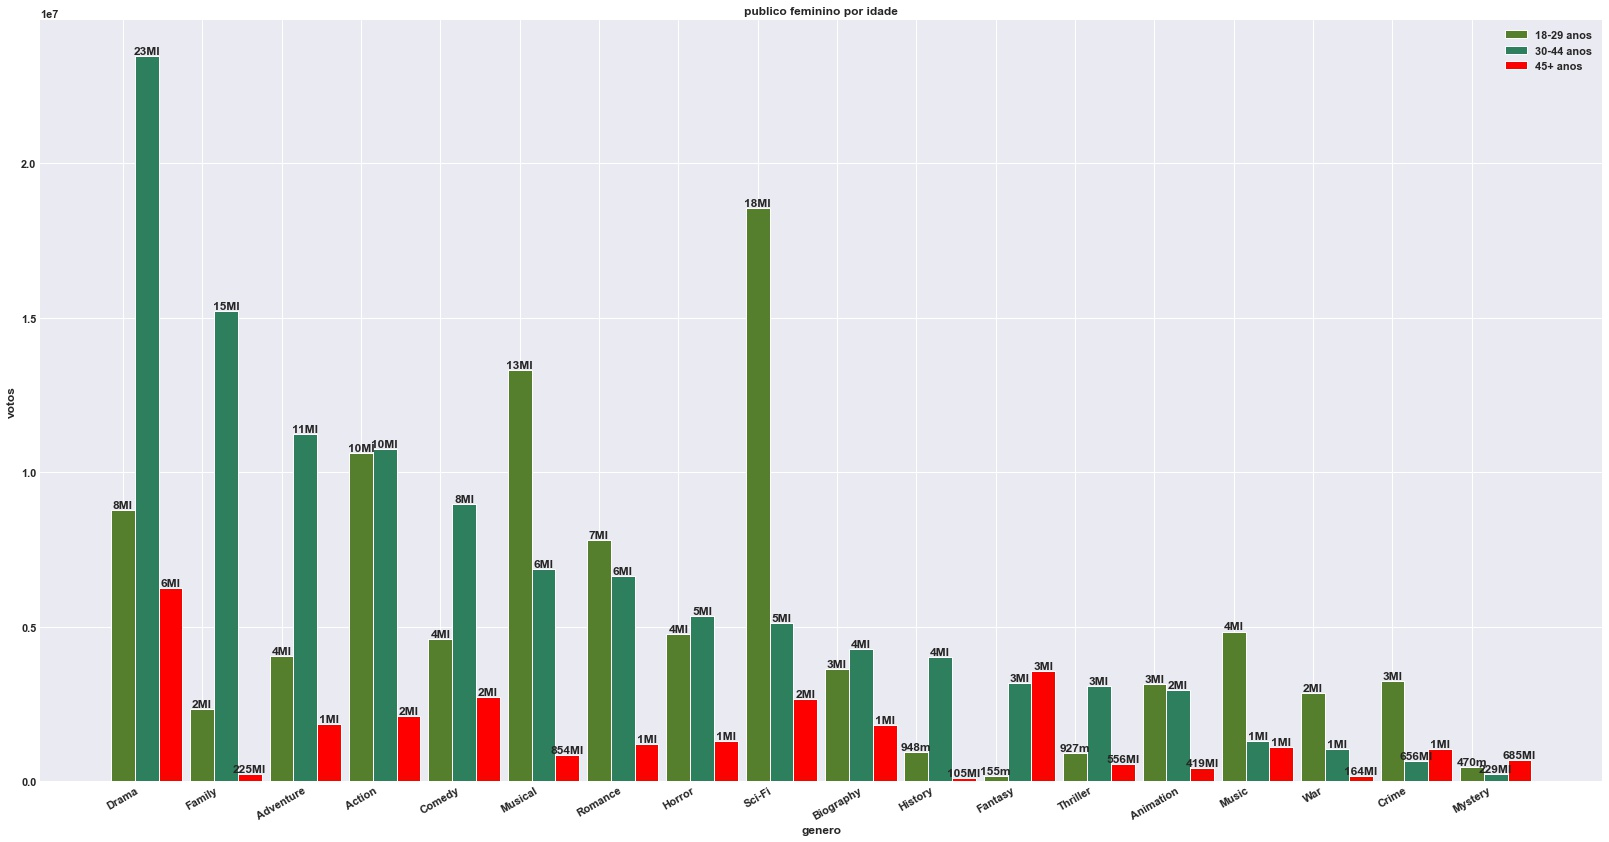

In [145]:
rc('font', weight='bold')
df_final_f.sort_values('30-44 anos',ascending=False,inplace=True)
plt.figure(figsize = (28,14))
barWidth = 0.3
bars1 = df_final_f['0-17 anos'].drop(index=[21,20,19,18])
bars2 = df_final_f['18-29 anos'].drop(index=[21,20,19,18])
bars3 = df_final_f['30-44 anos'].drop(index=[21,20,19,18])
bars4 = df_final_f['45+ anos'].drop(index=[21,20,19,18])


r1 = np.arange(len(bars2))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

names = df_final_f['genre'].drop(index=[21,20,19,18])

#gra1 = plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='0-17 anos')
gra2 = plt.bar(r1, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='18-29 anos')
gra3 = plt.bar(r2, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='30-44 anos')
gra4 = plt.bar(r3, bars4, color='red', width=barWidth, edgecolor='white', label='45+ anos')


for rect in gra2:
    height = rect.get_height()
    nome = '{0:,}'.format(int(height))
    if len(nome)>7:
        unidade = 'MI'
    elif len(nome)<=7:
        unidade = 'm'
    plt.text(rect.get_x() + rect.get_width()/2.0, height, nome[0:nome.index(',')]+unidade, ha='center', va='bottom')

for rect in gra3:
    height = rect.get_height()
    nome = '{0:,}'.format(height)
    if len(nome)>7:
        unidade = 'MI'
    elif len(nome)<=7:
        unidade = 'm'
    plt.text(rect.get_x() + rect.get_width()/2.0, height, nome[0:nome.index(',')]+unidade, ha='center', va='bottom')

for rect in gra4:
    height = rect.get_height()
    nome = '{0:,}'.format(height)
    if len(nome)>7:
        unidade = 'MI'
    elif len(nome)<=7:
        unidade = 'm'
    plt.text(rect.get_x() + rect.get_width()/2.0, height, nome[0:nome.index(',')]+unidade, ha='center', va='bottom')



r = np.arange(0,18)

plt.xticks(rotation=30)
plt.xticks(r, names, fontweight='bold')
plt.xlabel('genero', fontweight='bold')
plt.ylabel('votos', fontweight='bold')

plt.title('publico feminino por idade', fontweight = 'bold')
plt.legend()
plt.show()

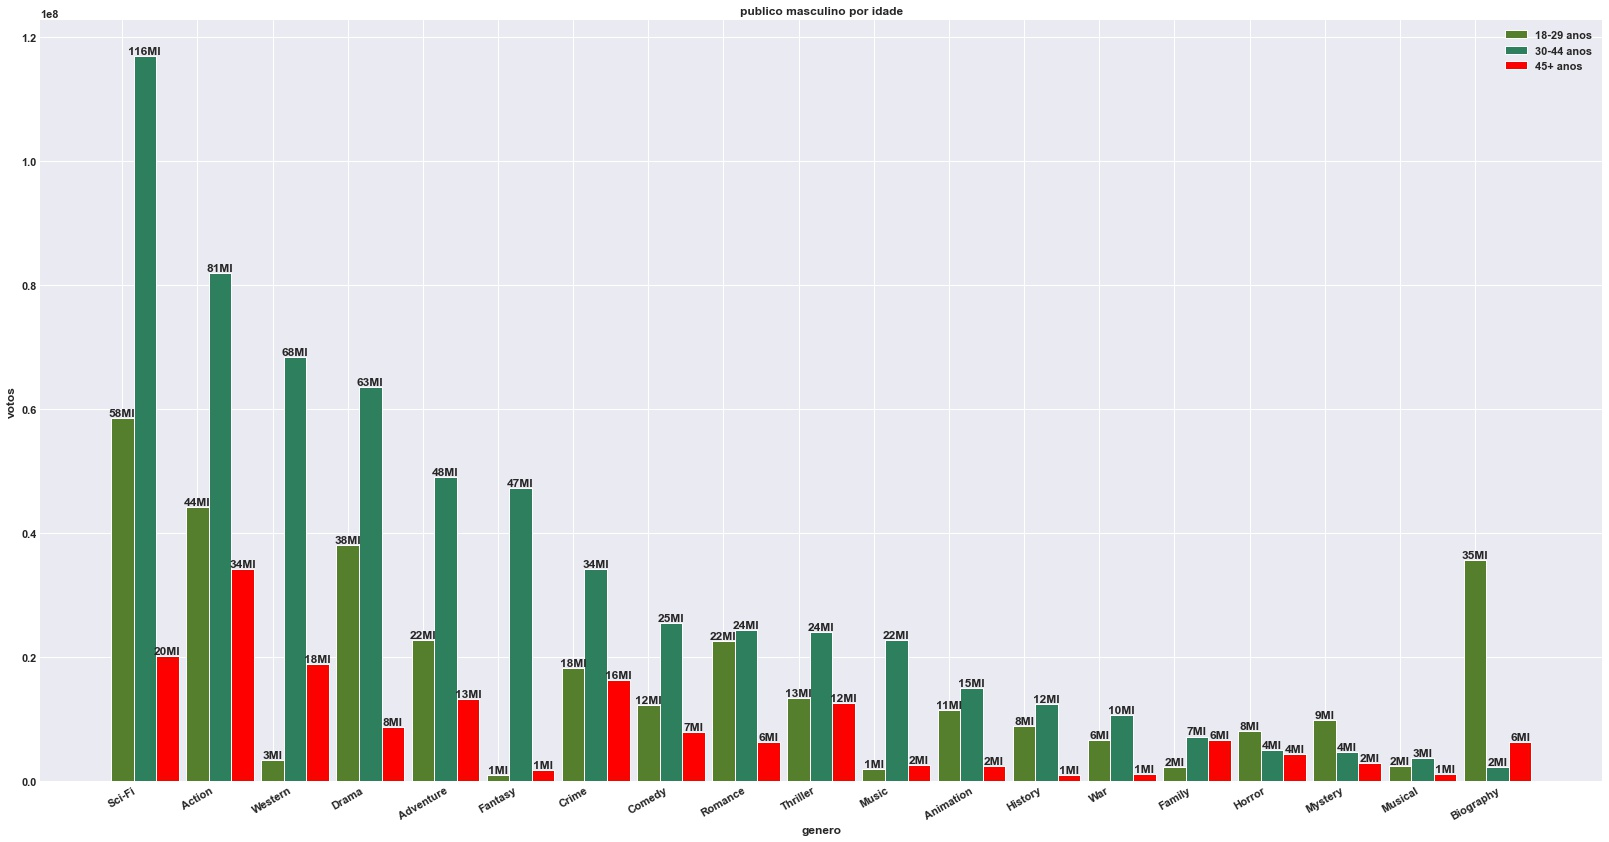

In [146]:
rc('font', weight='bold')
df_final_m.sort_values('30-44 anos',ascending=False,inplace=True)
plt.figure(figsize = (28,14))
barWidth = 0.3
bars1 = df_final_m['0-17 anos'].drop(index=[22,21,20,17])
bars2 = df_final_m['18-29 anos'].drop(index=[22,21,20,17])
bars3 = df_final_m['30-44 anos'].drop(index=[22,21,20,17])
bars4 = df_final_m['45+ anos'].drop(index=[22,21,20,17])


r1 = np.arange(len(bars2))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

names = df_final_m['genre'].drop(index=[22,21,20,17])

#gra1 = plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='0-17 anos')
gra2 = plt.bar(r1, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='18-29 anos')
gra3 = plt.bar(r2, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='30-44 anos')
gra4 = plt.bar(r3, bars4, color='red', width=barWidth, edgecolor='white', label='45+ anos')


for rect in gra2:
    height = rect.get_height()
    nome = '{0:,}'.format(int(height))
    if len(nome)>7:
        unidade = 'MI'
    elif len(nome)<=7:
        unidade = 'm'
    plt.text(rect.get_x() + rect.get_width()/2.0, height, nome[0:nome.find(',')]+unidade, ha='center', va='bottom')

for rect in gra3:
    height = rect.get_height()
    nome = '{0:,}'.format(int(height))
    if len(nome)>7:
        unidade = 'MI'
    elif len(nome)<=7:
        unidade = 'm'
    plt.text(rect.get_x() + rect.get_width()/2.0, height, nome[0:nome.find(',')]+unidade, ha='center', va='bottom')

for rect in gra4:
    height = rect.get_height()
    nome = '{0:,}'.format(int(height))
    if len(nome)>7:
        unidade = 'MI'
    elif len(nome)<=7:
        unidade = 'm'
    plt.text(rect.get_x() + rect.get_width()/2.0, height, nome[0:nome.find(',')]+unidade, ha='center', va='bottom')



r = np.arange(0,len(gra2))

plt.xticks(rotation=30)
plt.xticks(r, names, fontweight='bold')
plt.xlabel('genero', fontweight='bold')
plt.ylabel('votos', fontweight='bold')


plt.title('publico masculino por idade', fontweight = 'bold')
plt.legend()
plt.show()

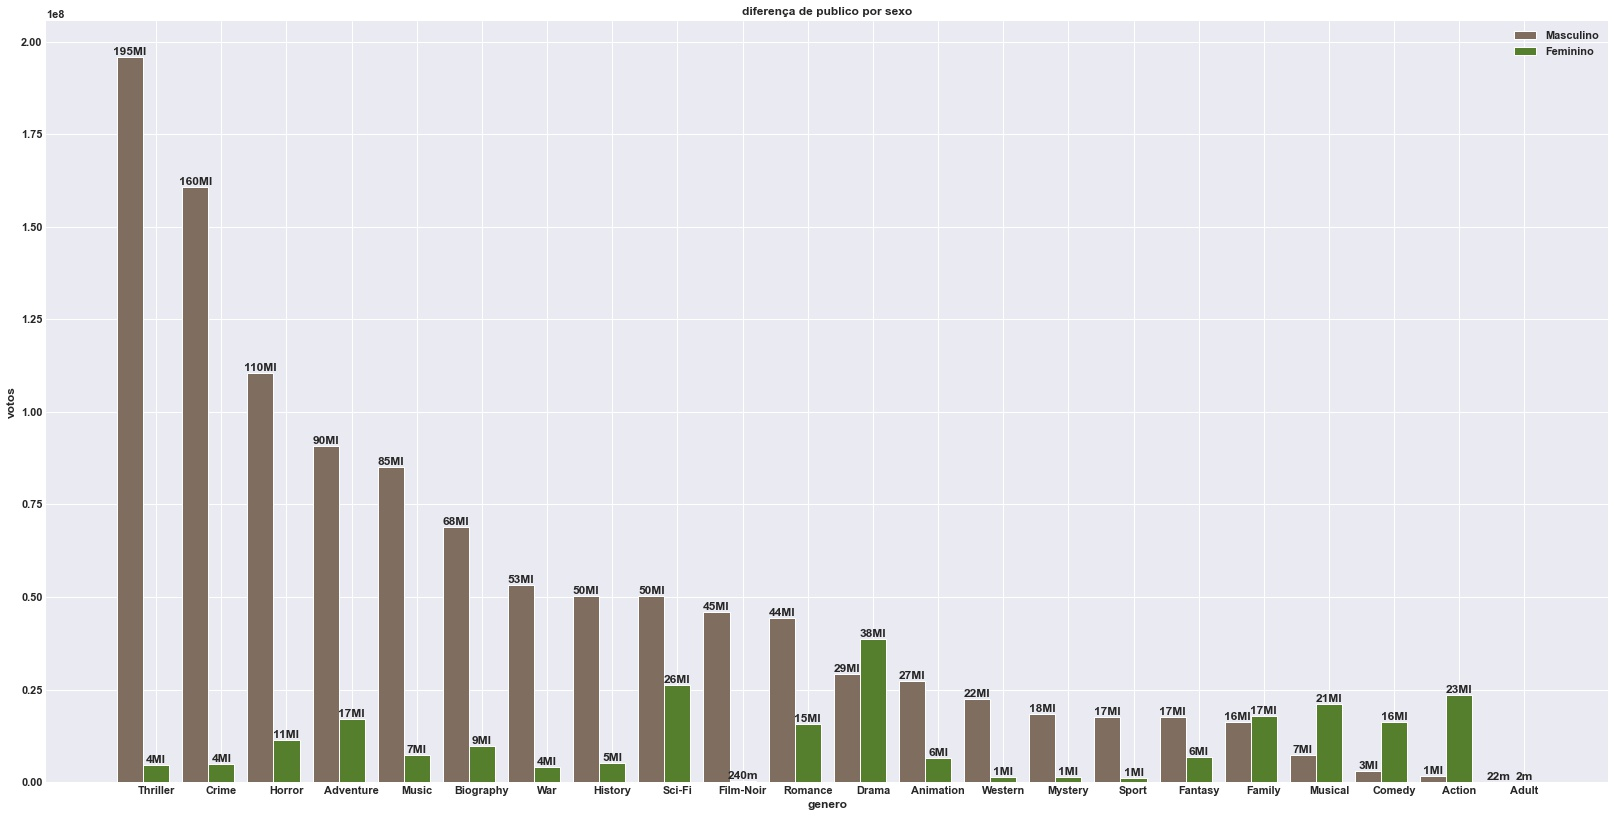

In [61]:
barWidth = 0.4
plt.figure(figsize = (28,14))
generos = set(df_final_m['genre'].to_list()) & set(df_final_f['genre'].to_list())

barsm = df_final_m.set_index('genre').loc[generos].sort_values('all',ascending=False)['all']
barsf = df_final_f.set_index('genre').loc[generos]['all']

r1 = np.arange(len(barsm))
r2 = [x + barWidth for x in r1]

gra2 = plt.bar(r1, barsm, color='#7f6d5f', width=barWidth, edgecolor='white', label='Masculino')
gra3 = plt.bar(r2, barsf, color='#557f2d', width=barWidth, edgecolor='white', label='Feminino')

for rect in gra2:
    height = rect.get_height()
    nome = '{0:,}'.format(int(height))
    if len(nome)>7:
        unidade = 'MI'
    elif len(nome)<=7:
        unidade = 'm'
    plt.text(rect.get_x() + rect.get_width()/2.0, height, nome[0:nome.find(',')]+unidade, ha='center', va='bottom')

for rect in gra3:
    height = rect.get_height()
    nome = '{0:,}'.format(int(height))
    if len(nome)>7:
        unidade = 'MI'
    elif len(nome)<=7:
        unidade = 'm'
    plt.text(rect.get_x() + rect.get_width()/2.0, height, nome[0:nome.find(',')]+unidade, ha='center', va='bottom')


plt.xlabel('genero', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(barsm))], df_final_f.set_index('genre').loc[generos].index)
plt.xlabel('genero', fontweight='bold')
plt.ylabel('votos', fontweight='bold')

plt.title('diferença de publico por sexo', fontweight = 'bold')
plt.legend()
plt.show()

## Todos os diretores com filmes, nota media, e o numero total de avaliacoes recebidas, e o principal genero dos seus filmes

In [65]:
%%time
#selecionando dados
diretores = mov[['imdb_title_id','title','director','genre']].merge(rat[['imdb_title_id','total_votes', 'mean_vote']], on = 'imdb_title_id')

#preparando dados
#diretores['genre'] = diretores['genre'].str.split(', ')
diretores['title'] = diretores['title'].str.split(', ')

#re-empacotando dados
agg_dict = {'title':'sum',
            'genre':'sum',
            'total_votes':'sum',
            'mean_vote':'mean'
           }
diretores = diretores.groupby('director').agg(agg_dict)

#selecionando os generos mais feitos por diretor
diretores['title'] = diretores['title'].map(lambda x: multimode(x))
diretores['genre'] = diretores['genre'].map(lambda x: multimode(x))

#organizando dataframe por popularidade do diretor
diretores.sort_values('total_votes',ascending=False,inplace=True)


Wall time: 7.66 s


### Diretores mais bem sucedidos, relacionado com as notas dos filmes e a popularidade dos filmes

In [67]:
top_v1 = diretores[(diretores['mean_vote'] > diretores['mean_vote'].quantile(0.70)) & (diretores['total_votes'] > diretores['total_votes'].quantile(0.999))].sort_values('mean_vote',ascending=False).head(30).sort_values('mean_vote',ascending=False).head(10)

Text(0.5, 1.0, 'diretores mais bem sucedidos, relacao entre quantidade de votos e media')

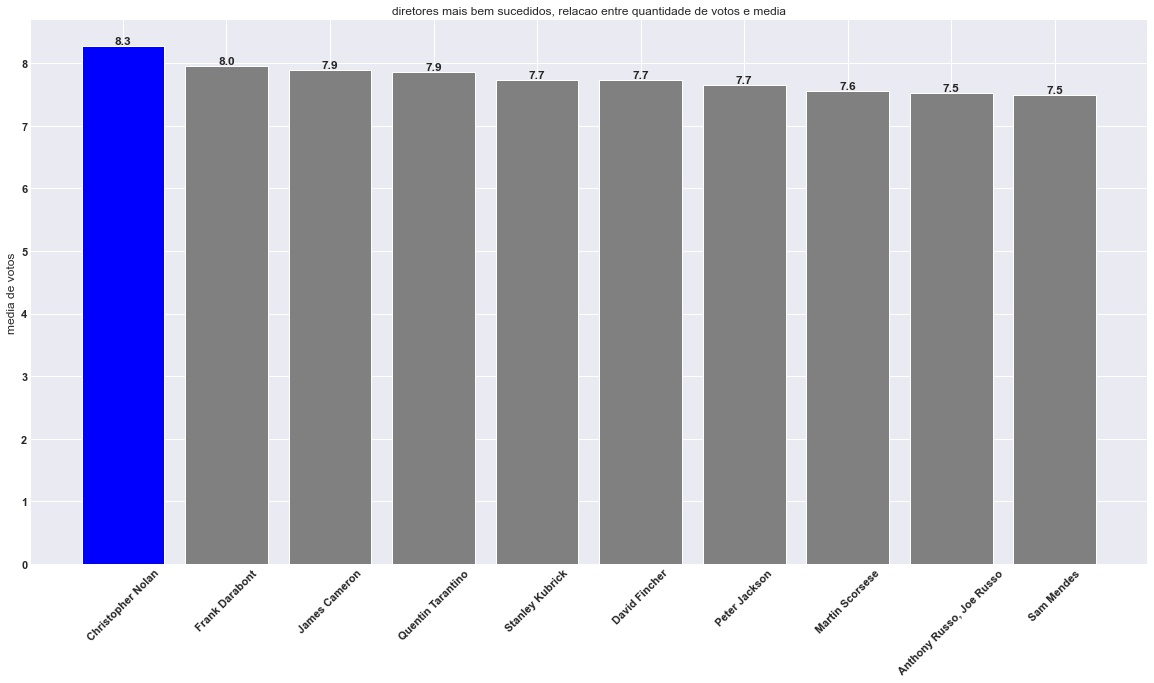

In [80]:
plt.figure(figsize = (20,10))
plt.xticks(rotation=45)
gra = plt.bar(top_v1.index, top_v1['mean_vote'], color = [
    'blue',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5'],
    edgecolor = 'white')
for rect in gra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{0:,}'.format(round(height,1)).replace(',','.'), ha='center', va='bottom')
plt.ylabel('media de votos')
plt.title('diretores mais bem sucedidos, relacao entre quantidade de votos e media')

### Diretores mais bem sucedidos, por score (total de votos * media)

In [69]:
diretores['score'] = diretores['total_votes']*diretores['mean_vote']

In [70]:
top_v2 = diretores.sort_values('score',ascending=False).head(10)

Text(0.5, 1.0, 'diretores mais bem sucedidos por score(media*quantidade de votos)')

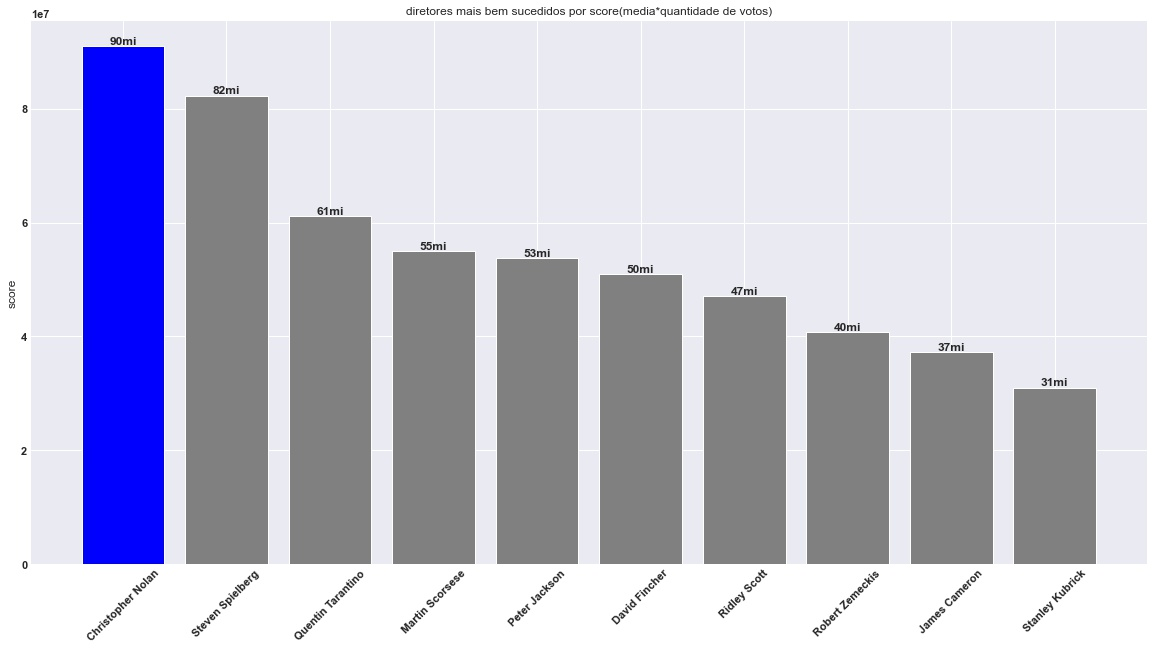

In [79]:
plt.figure(figsize = (20,10))
plt.xticks(rotation=45)
gra = plt.bar(top_v2.index, top_v2['score'], color = [
    'blue',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5'],
    edgecolor = 'white')
for rect in gra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, str(height)[0:'{0:,}'.format(height).index(',')]+'mi', ha='center', va='bottom')
plt.ylabel('score')
plt.title('diretores mais bem sucedidos por score(media*quantidade de votos)')

## Filmes do Star Wars

### Filmes mais rentaveis do Star Wars

In [143]:
SW = rentaveis2[rentaveis2['title'].map(lambda x: 'Star Wars' in x)]
SW.sort_values('rentabilidade (%)', ascending=False, inplace=True)

<ipython-input-143-7eac6c5cccdc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SW.sort_values('rentabilidade (%)', ascending=False, inplace=True)


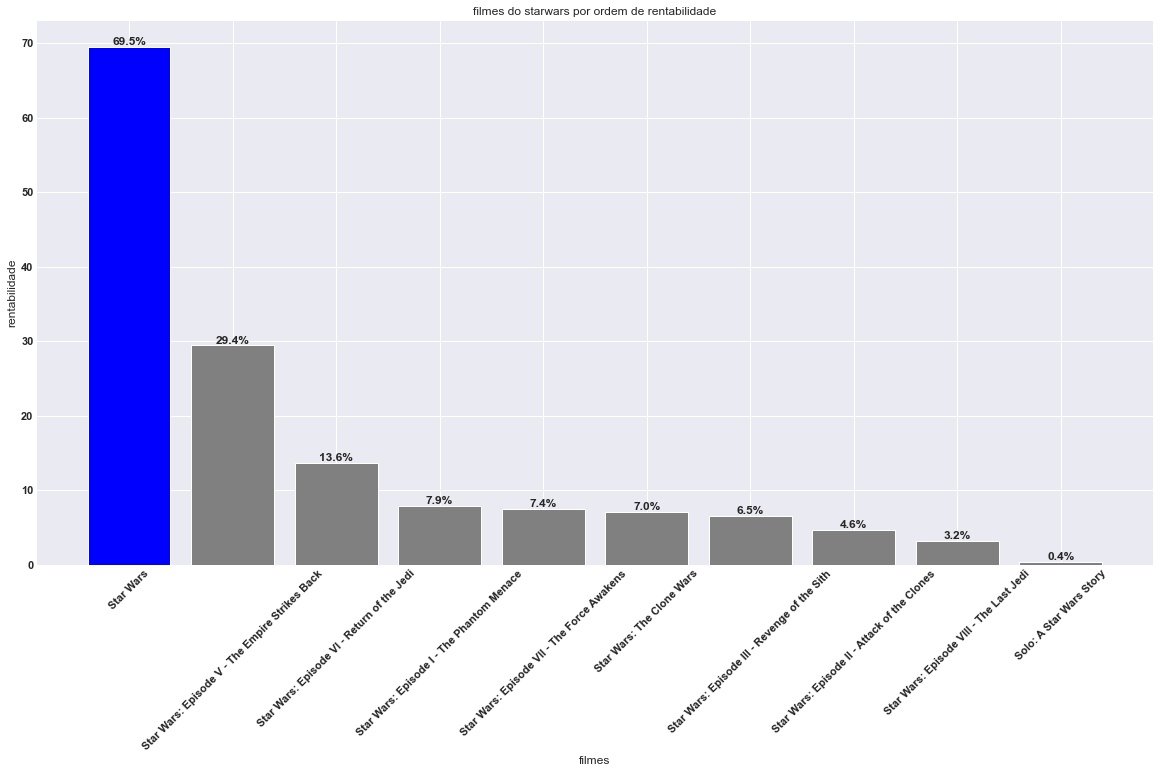

In [144]:
plt.figure(figsize = (20,10))
plt.xticks(rotation=45)
gra = plt.bar(SW['title'], SW['rentabilidade (%)'], color = [
    'blue',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5',
    '0.5'],
    edgecolor = 'white')
for rect in gra:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{0:,}'.format(round(height,1)).replace(',','.')+'%', ha='center', va='bottom')
plt.ylabel('rentabilidade')
plt.xlabel('filmes')
plt.title('filmes do starwars por ordem de rentabilidade')

plt.show()